In [36]:
import os, importlib, sys, time

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [39]:
import freqepid

In [40]:
from tqdm import tqdm

# 1. parameters

In [41]:
T = 120
T0 = 40

In [42]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [43]:
r_Y = 10

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [66]:
d = 3
betas = np.array([
    np.linspace(-np.log(5.5)-0.5, -np.log(5.5)+0.5, 21),     
    np.linspace(0, 0, 21),
    np.linspace(0, -1, 21),
]).T

In [67]:
r_I = 10
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

In [46]:
mu = np.log(100)

$$I_{[-T_0,0)} = \exp(\mu_0)$$

## simulation setting

In [47]:
num_beta = 21
num_sim = 100

# 2. Fit

In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [49]:
model = freqepid.Model(GPi['g'], [1], 1, K, T0, "nbinom")

In [50]:
nsim = np.zeros((num_beta,num_sim))
msim = np.zeros((num_beta,num_sim))
bsim = np.zeros((num_beta,num_sim,d))

In [51]:
for iter_beta in tqdm(np.arange(num_beta), desc='beta', leave=None, position=0):
    data = pd.read_feather('data/simulation_phantom_%.2d.feather'%iter_beta)
    
    for iter_sim in tqdm(np.arange(num_sim), desc='SIM', leave=None, position=0):
        start_sim = time.time()
        
        data_i = data[data['sim']==iter_sim]
        A = np.stack([np.full(T, 1), data_i["covariate"].to_numpy(), 
                      data_i["intervention"].to_numpy()], -1)
        Y = data_i["death"].to_numpy()
        
        # fit
        nmle, mmle, bmle, ll =\
        model.fit(A, Y, n_iter=100, step_size=1,
                  history=False, verbose=False)
        
        nsim[iter_beta,iter_sim] = nmle
        msim[iter_beta,iter_sim] = mmle
        bsim[iter_beta,iter_sim] = bmle

beta: 100%|███████████████████████████████████| 21/21 [1:16:08<00:00, 217.57s/it]


In [59]:
np.savez('result_phantom_ML.npz',
         nsim = nsim, msim = msim, bsim = bsim)

# 3. Result

In [60]:
result = np.load('result_phantom_ML.npz')
bsim = result['bsim']

In [61]:
from matplotlib import ticker

In [62]:
betas[:,-1]

array([ 0.  , -0.05, -0.1 , -0.15, -0.2 , -0.25, -0.3 , -0.35, -0.4 ,
       -0.45, -0.5 , -0.55, -0.6 , -0.65, -0.7 , -0.75, -0.8 , -0.85,
       -0.9 , -0.95, -1.  ])

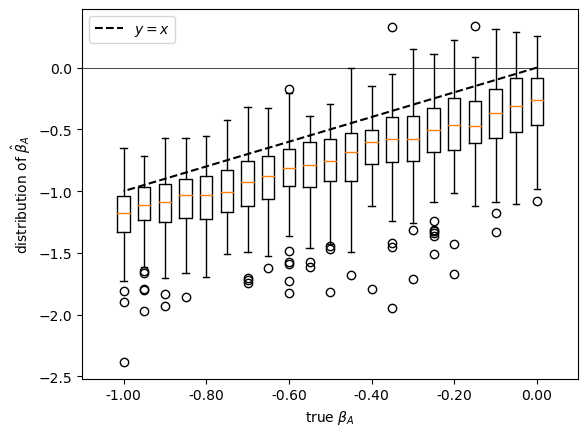

In [63]:
plt.boxplot(bsim[:,:,-1].T, positions=betas[:,-1], widths=0.03)
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.axhline(y=0, linewidth=0.5, color='black')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.ylabel(r'distribution of $\hat\beta_A$'); plt.xlabel(r'true $\beta_A$'); plt.legend()
plt.show()

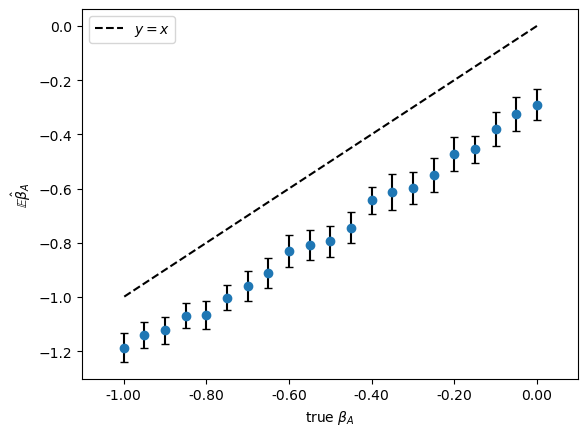

In [65]:
plt.errorbar(betas[:,-1], np.mean(bsim[:,:,-1], -1), yerr=2*np.std(bsim[:,:,-1],-1)/10, 
             ecolor='black', capsize=3, fmt="o")
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.xlabel(r'true $\beta_A$'); plt.ylabel(r'$\mathbb{E}\hat\beta_A$'); plt.legend()
plt.show()